In [8]:
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from tsseg.utils import *
from tsseg.omslr import *
from tsseg.greed import *

import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")

%load_ext autoreload
%autoreload 2

db = myclient['TSE-DB']
#------------------- read the raw price panel------------------##
collection = db['raw_price_panel']
# df = pd.read_parquet("D:\Documents-C\BTCUSD_1 Min_Ask_2017.05.08_2023.03.22.parquet")
# df = df.iloc[:300, 1]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Added Delay in order to use windows to determine the right number of K.

Note: `n=0` breaks the code needs to be fixed later

In [9]:
back_prop = 126
stock_name = "شاوان"
n_delay = 6

In [10]:
price_data = (
    pd.DataFrame(collection.find({}))
    .drop(columns=["_id"])
    .set_index("J-Date")
    .astype(np.float32)
)
df = price_data[stock_name].dropna()[-back_prop-n_delay:-n_delay].copy(deep=True)
x = df.to_list()
sigma_iter, beta, alpha = iter_sigma(x)
# print(sigma_iter)


In [11]:
res_lst = np.array([])
for k in range(2, (np.ceil(len(x) / 3) + 1).astype(int)):
    gamma, rho = omslr_gmse(x, sigma=sigma_iter, max_k=k)
    pvt_points = get_pivots(gamma=gamma)
    segments, durations, slopes, errors = get_segments(
        x=x, pivots=pvt_points, sigma=sigma_iter, beta=beta
    )
    res = np.sum(np.array(errors) ** 2)
    res_lst = np.append(res_lst, res)


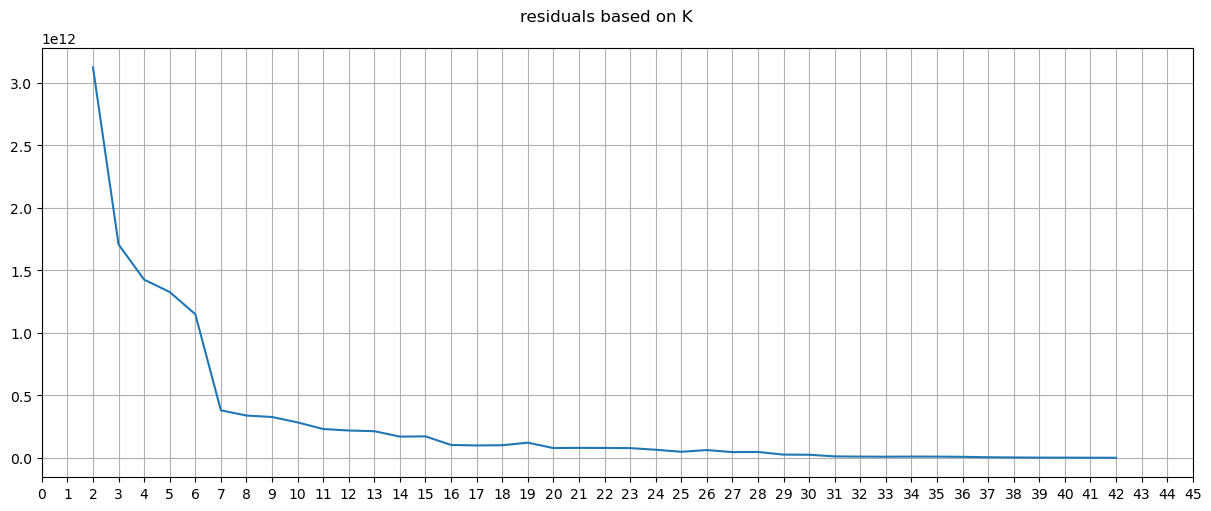

In [12]:
plt.figure(figsize=(12, 5), layout="constrained")
plt.plot(np.arange(2, len(res_lst) + 2), res_lst)
plt.xticks(np.arange(0, len(res_lst) + 5, 1.0))
plt.suptitle("residuals based on K")
plt.grid()
plt.show()


- In order to find the optimal point by reducing the number K points we can decide which points are the most fundamental ones and see which points are really close and omit them.
- So I need to experiment a little around the number of K which breaks the slope of the diagram
- Try to find the minimum number of K with specific erros
- Using Windows with delays helps in determining which breakpoints are the most important ones

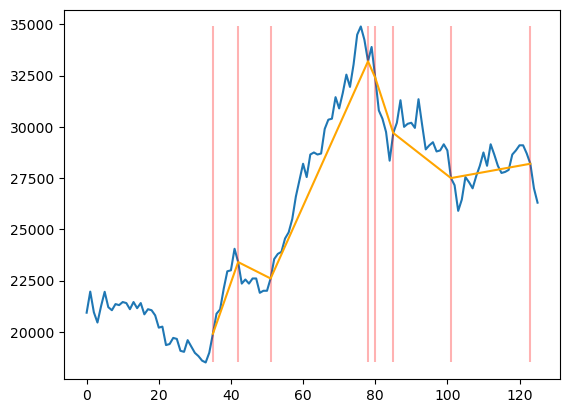

Breakpoints are: [35, 42, 51, 78, 80, 85, 101, 123]


In [13]:
gamma, rho = omslr_gmse(x, sigma=sigma_iter, max_k=8)
pvt_points = get_pivots(gamma=gamma)
y = np.array(x).astype(int)


fig, ax = plt.subplots()
ax.plot(x)
ax.vlines(x=pvt_points, ymin=min(x), ymax=max(x), color="r", alpha=0.3)
ax.plot(pvt_points, y[pvt_points], color="orange")
plt.show()

print(
    "Breakpoints are:",
    pvt_points
)